/tmp/ipykernel_13291/3663811415.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start, end, freq=freq, inclusive="right")


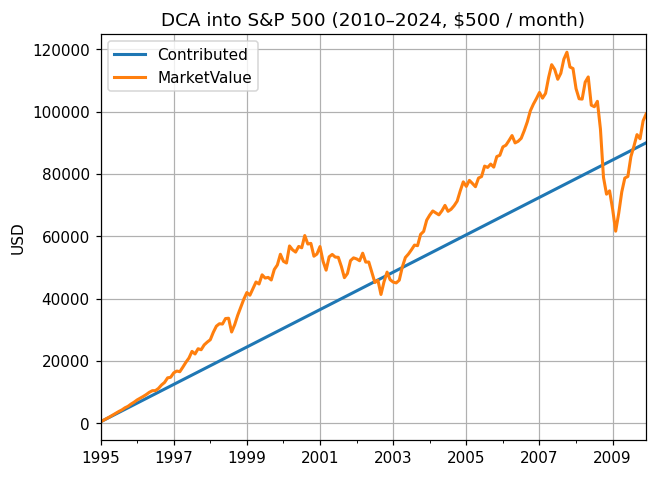

Figure saved to sp500_return_heatmap.png


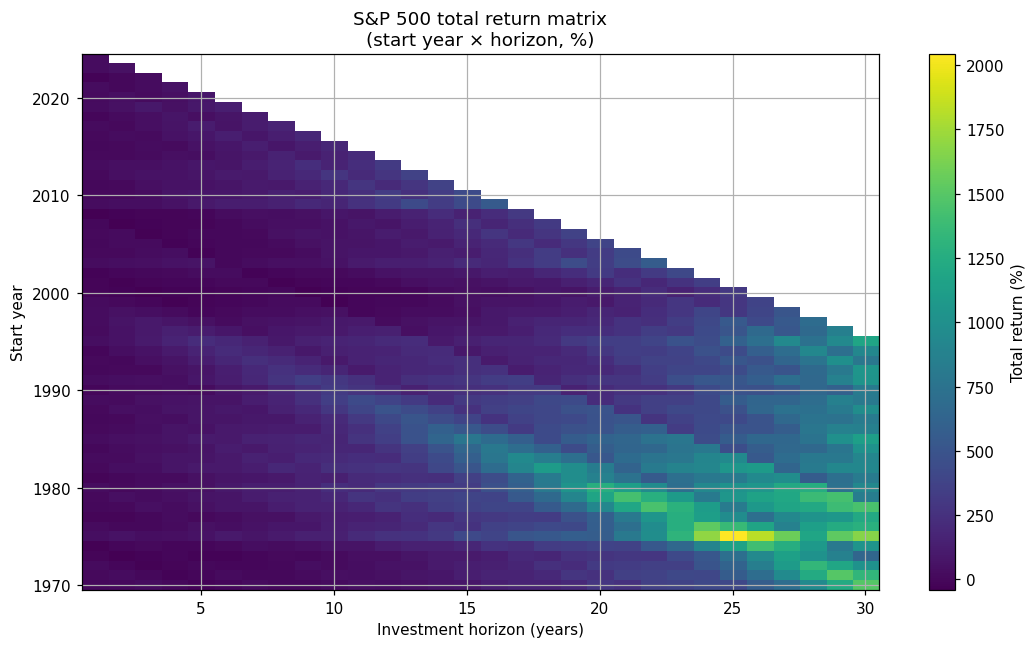

In [26]:
# ======================  インポートと共通設定  =============================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110        # 画面用に高解像度
plt.rcParams["axes.grid"] = True        # グリッドを付けて見やすく

# S&P500 ヒストリカル日次データを DL
spx = yf.download("^GSPC", start="1950-01-01", progress=False)
spx = spx.iloc[:, 0]
spx.name = "price"

# 補助関数: ある日付まで積立した評価額と拠出累計を返す ---------------------
def dca_series(price: pd.Series,
               start: str,
               end: str,
               freq: str = "M",
               contribution: float = 500.0):
    """
    price        : S&P500 終値 Series
    start, end   : 'YYYY-MM-DD'
    freq         : 'M', 'W', 'D' など pandas オフセットコード
    contribution : 毎回拠出額 (USD)
    return       : DataFrame[Contributed, MarketValue]
    """
    # 1) 買付日（右閉区間；例では毎月末）
    dates = pd.date_range(start, end, freq=freq, inclusive="right")

    # 2) 買付日の終値
    buys = price.reindex(dates, method="ffill")

    # 3) 当日の買付株数
    shares_bought = contribution / buys

    # 4) 累積株数
    shares_cum = shares_bought.cumsum()

    # 5) 評価額 ＝ 累積株数 × 当日の終値（評価時点での終値で OK）
    price_aligned = price.reindex(shares_cum.index, method="ffill")
    market_value = shares_cum * price_aligned            # ← Series

    # 6) 拠出累計（同じインデックスで Series 化）
    contrib_cum = pd.Series(
        np.arange(1, len(shares_cum) + 1) * contribution,
        index=shares_cum.index,
        name="Contributed"
    )

    # 7) DataFrame にまとめて返す
    return pd.DataFrame({
        "Contributed": contrib_cum,
        "MarketValue": market_value
    })


# ======================  ① 積立推移ラインチャート  =========================
dca = dca_series(spx,
                 start="1995-01-01",
                 end  ="2009-12-31",
                 freq ="M",
                 contribution=500)

fig1, ax1 = plt.subplots()
dca.plot(ax=ax1, linewidth=2)
ax1.set_title("DCA into S&P 500 (2010–2024, $500 / month)")
ax1.set_ylabel("USD")

out_file = "sp500_return_heatmap.png"      # 保存先ファイル名
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print(f"Figure saved to {out_file}")

plt.show()

# ======================  ② 開始年 × 投資期間ヒートマップ  =================
# パラメータ範囲
start_years  = range(1970, 2025)     # 1970-2024
horizons     = range(1, 31)          # 1-30年

heat = pd.DataFrame(index=start_years, columns=horizons, dtype=float)

for yr in start_years:
    for h in horizons:
        s = f"{yr}-01-01"
        e = f"{yr+h}-01-01"
        if e > spx.index[-1].strftime("%Y-%m-%d"):
            continue  # 未来データはスキップ
        price_s = spx.asof(s)
        price_e = spx.asof(e)
        heat.at[yr, h] = price_e / price_s - 1.0   # 期間トータルリターン (%ではなく倍率-1)

fig2, ax2 = plt.subplots(figsize=(10, 6))
im = ax2.imshow(heat * 100,    # %
                aspect="auto",
                origin="lower",
                extent=[min(horizons)-0.5, max(horizons)+0.5,
                        min(start_years)-0.5, max(start_years)+0.5])

ax2.set_xlabel("Investment horizon (years)")
ax2.set_ylabel("Start year")
ax2.set_title("S&P 500 total return matrix\n(start year × horizon, %)")
cbar = fig2.colorbar(im, ax=ax2, label="Total return (%)")

out_file = "sp500_return_heatmap.png"      # 保存先ファイル名
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print(f"Figure saved to {out_file}")

plt.tight_layout()
plt.show()


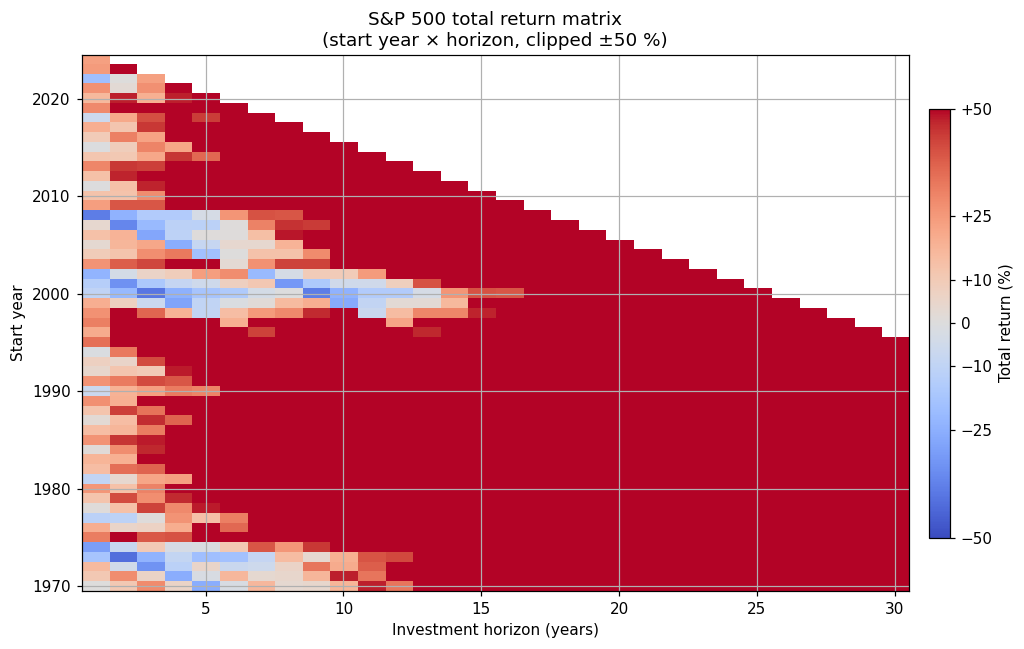

In [22]:
from matplotlib.colors import TwoSlopeNorm
# 1) ±50% でクリップ（ここは好みで ±30%、±100% などに調整可）
heat_clip = heat.clip(lower=-0.5, upper=0.5)

# 2) 描画
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(
    heat_clip * 100,                    # ％表示
    aspect="auto",
    origin="lower",
    extent=[min(horizons)-0.5, max(horizons)+0.5,
            min(start_years)-0.5, max(start_years)+0.5],
    cmap="coolwarm",                    # 発散系カラーマップ
    norm=TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)  # 中央0％
)

ax.set_xlabel("Investment horizon (years)")
ax.set_ylabel("Start year")
ax.set_title("S&P 500 total return matrix\n(start year × horizon, clipped ±50 %)")

# 3) カラーバーは小刻みな目盛りで
cbar = fig.colorbar(im, ax=ax, label="Total return (%)", shrink=0.8, pad=0.02)
cbar.set_ticks([-50, -25, -10, 0, 10, 25, 50])
cbar.ax.set_yticklabels(["−50", "−25", "−10", "0", "+10", "+25", "+50"])

plt.tight_layout()
plt.show()

In [15]:
spx = yf.download("^GSPC", start="1950-01-01", progress=False)

In [17]:
spx = spx.iloc[:, 0]

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

spx = yf.download("^GSPC", start="1950-01-01", progress=False)["Close"]
spx.name = "price"
start="2010-01-01"
end  ="2024-12-31"
freq ="M"
contribution=500
price = spx
dates = pd.date_range(start, end, freq=freq, inclusive="right")
buys = price.reindex(dates, method="ffill")
# 3) 当日の買付株数
shares_bought = contribution / buys
# 4) 累積株数
shares_cum = shares_bought.cumsum()
# 5) 評価額 ＝ 累積株数 × 当日の終値（評価時点での終値で OK）
price_aligned = price.reindex(shares_cum.index, method="ffill")
market_value = shares_cum * price_aligned            # ← Series
# 6) 拠出累計（同じインデックスで Series 化）
contrib_cum = pd.Series(
    np.arange(1, len(shares_cum) + 1) * contribution,
    index=shares_cum.index,
    name="Contributed"
)

/tmp/ipykernel_13291/1354029553.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start, end, freq=freq, inclusive="right")


In [13]:
dca = pd.DataFrame({
        "Contributed": contrib_cum,
        "MarketValue": market_value
    })

ValueError: Data must be 1-dimensional, got ndarray of shape (180, 1) instead